### Regression using Xgboost

This dataset is avaliable on

http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant


The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 

Features consist of hourly average ambient variables 
1. Temperature (AT)
2. Exhaust Vacuum (V) 
3. Ambient Pressure (AP)
4. Relative Humidity (RH) 
5. hourly electrical energy output (EP) --> Predctions

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.

###### Soulution:
Training a xgboost regression on provided data after combining all five shffled sheets

In [1]:
# inputs
datapath = './CCPP/'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor


print('pandas:', pd.__version__)
print('numpy:', np.__version__)
print('sklearn:', pd.__version__)
print('xgboost:', xgb.__version__)

%matplotlib inline

pandas: 0.21.0
numpy: 1.13.3
sklearn: 0.21.0
xgboost: 0.6


In [3]:
# read data sets
df = pd.read_excel(datapath + 'Folds5x2_pp.xlsx',sheet_name=['Sheet1','Sheet2','Sheet3','Sheet4','Sheet5'])
df = pd.concat(df).reset_index()
df.drop(['level_0','level_1'],axis=1,inplace=True)

df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
# Sampling
trainx, valx, trainy, valy = train_test_split(df.drop(['PE'],axis=1),df['PE'],test_size=.3,random_state =2017)

In [5]:
# Creating dmatrix for training and validation
dtrain = xgb.DMatrix(data=trainx,label=trainy)
dval = xgb.DMatrix(data=valx,label=valy)

In [6]:
# defining xgb parameters
parms = {'booster': 'gbtree', #gblinear/gbtree
         'objective': 'reg:linear', 
         'eval_metric': 'rmse',
         # 'tree_method' : 'hist',
         'eta': 0.1, 
         'subsample': 0.8, 
         'colsample_bytree': 0.8, 
         'lambda': 5, # L2 regularization(gblinear)
         'alpha': 1, # L1 regularization(gblinear)
         'lambda_bias': 0, # L2 regularization term on bias(gblinear)
         'max_depth': 50, 
         'min_child_weight': 1,
         'gamma' : 10,
         'nthread': 8,
         'seed': 2017}

# Cross validation
cv_xgb = xgb.cv(params = parms, 
                dtrain = dtrain, 
                num_boost_round = 1000, # provide big number if booster is gblinear
                nfold = 5,
                early_stopping_rounds = 5,
                verbose_eval =50) # Look for early stopping that minimizes error

[0]	train-rmse:408.836+0.0414991	test-rmse:408.838+0.171169
[50]	train-rmse:3.41426+0.0138194	test-rmse:3.5655+0.0688014
[100]	train-rmse:0.9283+0.00438529	test-rmse:1.32696+0.0603563
[150]	train-rmse:0.808884+0.00501512	test-rmse:1.20539+0.0610328
[200]	train-rmse:0.767515+0.0045143	test-rmse:1.16395+0.064325
[250]	train-rmse:0.745012+0.00219382	test-rmse:1.14273+0.0665064
[300]	train-rmse:0.732243+0.00175586	test-rmse:1.13094+0.0664834
[350]	train-rmse:0.723528+0.00198397	test-rmse:1.12249+0.0677101
[400]	train-rmse:0.714859+0.0027205	test-rmse:1.11432+0.06794
[450]	train-rmse:0.706714+0.00358501	test-rmse:1.10659+0.0680919
[500]	train-rmse:0.701936+0.00409616	test-rmse:1.10211+0.0685025
[550]	train-rmse:0.696937+0.00294532	test-rmse:1.09728+0.0680906
[600]	train-rmse:0.692573+0.0031289	test-rmse:1.09309+0.0694192
[650]	train-rmse:0.688614+0.00296552	test-rmse:1.08917+0.0694664
[700]	train-rmse:0.686309+0.00295413	test-rmse:1.0869+0.0696106
[750]	train-rmse:0.683353+0.00339899	test-r

In [7]:
# Training
trainrounds = cv_xgb.shape[0] # You can give it manually

fit_xgb = xgb.train(params=parms,
                    dtrain=dtrain,
                    evals = [(dtrain, 'train'),(dval, 'val')],
                    num_boost_round=trainrounds,
                    verbose_eval=50)

[0]	train-rmse:408.837	val-rmse:408.728
[50]	train-rmse:3.31851	val-rmse:3.44834
[100]	train-rmse:0.817789	val-rmse:1.08219
[150]	train-rmse:0.713337	val-rmse:0.970873
[200]	train-rmse:0.681491	val-rmse:0.936991
[250]	train-rmse:0.661886	val-rmse:0.915495
[300]	train-rmse:0.65361	val-rmse:0.906555
[350]	train-rmse:0.644155	val-rmse:0.89671
[400]	train-rmse:0.636829	val-rmse:0.888457
[450]	train-rmse:0.631608	val-rmse:0.882649
[500]	train-rmse:0.626937	val-rmse:0.877517
[550]	train-rmse:0.623393	val-rmse:0.873994
[600]	train-rmse:0.618948	val-rmse:0.869102
[650]	train-rmse:0.616163	val-rmse:0.86587
[700]	train-rmse:0.613471	val-rmse:0.863021
[750]	train-rmse:0.610525	val-rmse:0.859823
[789]	train-rmse:0.609338	val-rmse:0.858238


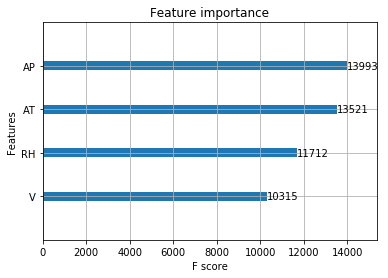

In [8]:
# fig, ax = plt.subplots(figsize=(10, 12))
xgb.plot_importance(fit_xgb)

In [9]:
def GetEvalMetrics(y_true, y_pred): 
    y_true = y_true.as_matrix()
    y_pred = y_pred.as_matrix()
    return round((1 - np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)),4), \
        round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,4)

In [10]:
valprd = pd.DataFrame({'Actual':dval.get_label(),'Predicted':fit_xgb.predict(dval)})
_, vMAPE = GetEvalMetrics(valprd['Actual'],valprd['Predicted'])

trnprd = pd.DataFrame({'Actual':dtrain.get_label(),'Predicted':fit_xgb.predict(dtrain)})
_, tMAPE = GetEvalMetrics(trnprd['Actual'],trnprd['Predicted'])

In [11]:
print('Train Metrics:\n')
print('R_Sqr: ',r2_score(trnprd['Actual'],trnprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(trnprd['Actual'],trnprd['Predicted'])))
print('MAPE: ',tMAPE)
print('Mean Absult Error: ',mean_absolute_error(trnprd['Actual'],trnprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(trnprd['Actual'],trnprd['Predicted']))

print('\nValdation Metrics:\n')
print('R_Sqr: ',r2_score(valprd['Actual'],valprd['Predicted']))
print('RMSE: ',np.sqrt(mean_squared_error(valprd['Actual'],valprd['Predicted'])))
print('MAPE: ',vMAPE)
print('Mean Absult Error: ',mean_absolute_error(valprd['Actual'],valprd['Predicted']))
print('Median Absult Error: ',median_absolute_error(valprd['Actual'],valprd['Predicted']))

Train Metrics:

R_Sqr:  0.998719366923
RMSE:  0.609338
MAPE:  0.1003
Mean Absult Error:  0.454846
Median Absult Error:  0.353638

Valdation Metrics:

R_Sqr:  0.997497446019
RMSE:  0.858238
MAPE:  0.1375
Mean Absult Error:  0.623032
Median Absult Error:  0.472321


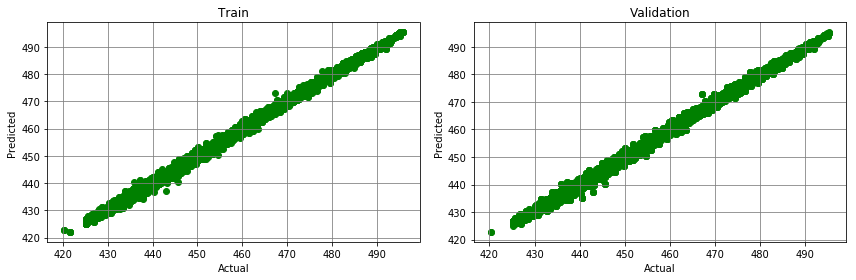

In [12]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.rc('grid', linestyle="-",color='grey')
plt.subplot(1,2,1)
plt.scatter(trnprd.Actual,trnprd.Predicted,color='green')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Train')
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(valprd.Actual,valprd.Predicted,color='green')
plt.title('Validation')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.grid(True)
plt.show()

In [13]:
TuneParm = {
 'max_depth':[50,55,60],
 'min_child_weight': [1,2,3]
}

GridPerms = [i for i in list(parms.keys()) if i not in list(TuneParm.keys())]
GridPerms = {k: v for k,v in parms.items() if k in GridPerms} 

In [14]:
gsearch = GridSearchCV(estimator = XGBRegressor(GridPerms,n_estimates=trainrounds),
                       param_grid = TuneParm,
                       return_train_score=True, 
                       scoring='mean_absolute_error',
                       n_jobs=-1, 
                       cv=5)
gsearch.fit(trainx,trainy)

print('Grid Search scores:\n',gsearch.cv_results_ )
print('\nGrid Search best settings:\n', gsearch.best_params_)
print('\nGrid Search best score:\n',  gsearch.best_score_)

Grid Search scores:
 {'mean_fit_time': array([ 10.02800269,  11.2351234 ,  11.20392027,  11.49054885,
        11.48894877,  11.53415327,  11.66616654,  11.69596949,  10.07640758]), 'std_fit_time': array([ 0.60754075,  0.22981514,  0.2082086 ,  0.24153659,  0.3266189 ,
        0.1372479 ,  0.21223994,  0.11092433,  0.47882164]), 'mean_score_time': array([ 0.45964599,  0.43524351,  0.43404346,  0.44604468,  0.43524361,
        0.44604464,  0.43864384,  0.45504546,  0.35183516]), 'std_score_time': array([ 0.07838279,  0.02374605,  0.04265627,  0.02858261,  0.0252564 ,
        0.03024885,  0.02019704,  0.04606102,  0.01209087]), 'param_max_depth': masked_array(data = [50 50 50 55 55 55 60 60 60],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'param_min_child_weight': masked_array(data = [1 2 3 1 2 3 1 2 3],
             mask = [False False False False False False False False False],
       fill_value = ?)
, 'params': [{'max_depth': 50

In [15]:
# Save model
fit_xgb.save_model('./model1.model')

In [16]:
# load model and score
scoremodel = xgb.Booster()
scoremodel.load_model('./model1.model')
scoremodel.predict(dval)

array([ 456.60354614,  427.64520264,  444.13952637, ...,  425.93051147,
        470.45462036,  478.85742188], dtype=float32)